In [1]:
import mne
import scipy
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
import glob
import copy
from findpeaks import findpeaks
from numpy import linalg as LA
from scipy.stats import zscore, pearsonr
from scipy.io import savemat, loadmat
from scipy import signal
%matplotlib widget

In [2]:
def clean_features(feats, smooth=True, objflow=True):
    y = copy.deepcopy(feats)
    if not objflow:
        # discard the coordinate of the center if it is not object detection based optical flow 
        y = y[:,:-2]
    else:
        # recover unnormalized histogram
        # TODO: remove in the future version
        # y[:,0:8] = y[:,0:8] * np.expand_dims(y[:,8], axis=1)
        pass
    # interpolate NaN values (linealy)
    T, nb_feature = y.shape
    for i in range(nb_feature):
        # interpolate NaN values
        nans, x= np.isnan(y[:,i]), lambda z: z.nonzero()[0]
        if any(nans):
            f1 = scipy.interpolate.interp1d(x(~nans), y[:,i][~nans], fill_value='extrapolate')
            y[:,i][nans] = f1(x(nans))
        if smooth:
            # extract envelope by finding peaks and interpolating peaks with spline
            idx_peaks = scipy.signal.find_peaks(y[:,i])[0]
            idx_rest = np.setdiff1d(np.array(range(T)), idx_peaks)
            # consider use quadratic instead
            f2 = scipy.interpolate.interp1d(idx_peaks, y[:,i][idx_peaks], kind='cubic', fill_value='extrapolate')
            y[:,i][idx_rest] = f2(idx_rest)
    return y

## Data Loading

In [3]:
def multisub_data_org(subjects, video_id, folder, fsStim, bads, band=None, eog=False, regression=False, normalize=True, smooth=True, objflow=True):
    feats_path_folder = '../Feature extraction/features/'
    if objflow:
        feats_path = feats_path_folder + video_id + '_mask.npy'
    else:
        feats_path = feats_path_folder + video_id + '_flow.npy'
    feats = np.load(feats_path)
    feats = clean_features(feats, smooth=smooth, objflow=objflow)
    T = feats.shape[0]
    eeg_list = []
    hf_list = []
    N = len(subjects)
    for n in range(N):
        eeg_path = '../../Experiments/data/'+ subjects[n] +'/' + folder + '/' + video_id + '_eeg.set'
        eeg_prepro, fs, high_freq = utils.preprocessing(eeg_path, HP_cutoff = 0.5, AC_freqs=50, band=band, resamp_freqs=fsStim, bads=bads[n], eog=eog, regression=regression, normalize=normalize)
        eeg_channel_indices = mne.pick_types(eeg_prepro.info, eeg=True)
        eeg_downsampled, _ = eeg_prepro[eeg_channel_indices]
        eeg_downsampled = eeg_downsampled.T
        eeg_list.append(eeg_downsampled)
        if eeg_downsampled.shape[0] < T:
            T = eeg_downsampled.shape[0]
        hf_indices = mne.pick_types(high_freq.info, eeg=True)
        hf_downsampled, _ = high_freq[hf_indices]
        hf_downsampled = hf_downsampled.T
        hf_list.append(hf_downsampled)
        if hf_downsampled.shape[0] < T:
            T = hf_downsampled.shape[0] 
    # Clip data
    feats = feats[fsStim:T-fsStim, :]
    eeg_list = [np.expand_dims(eeg[fsStim:T-fsStim,:], axis=2) for eeg in eeg_list]
    hf_list = [np.expand_dims(eeg[fsStim:T-fsStim,:], axis=2) for eeg in hf_list]
    eeg_multisub = np.concatenate(tuple(eeg_list), axis=2)
    hf_multisub = np.concatenate(tuple(hf_list), axis=2)
    times = np.array(range(T))/fs
    return feats, eeg_multisub, hf_multisub, fs, times

In [4]:
%%capture
subjects = ['AS', 'YY', 'CM', 'SUB1','IR','SUB2','YZ']
bads = [[], ['B25'], ['A24'], ['B25'], ['B25'],['A11','B7','B25'],['B25','B31']]
folder = 'Single_obj'
eeg_path_folder = "../../Experiments/data/AS/Single_obj/"
video_ids = [dataset[0:2] for dataset in os.listdir(eeg_path_folder) if dataset.endswith('.set')]
features_list = []
eeg_multisub_list = []
hf_multisub_list = []
for video_id in video_ids:
    features, eeg_multisub, hf_multisub, fs, _ = multisub_data_org(subjects, video_id, folder, fsStim=30, bads=bads, band=[25,35], eog=True, regression=True, normalize=True, smooth=True, objflow=True)
    features_list.append(features) 
    eeg_multisub_list.append(eeg_multisub)
    hf_multisub_list.append(hf_multisub)
feature_concat = np.concatenate(tuple(features_list), axis=0)
# feature_concat = feature_concat/LA.norm(feature_concat)
eeg_multisub_concat = np.concatenate(tuple(eeg_multisub_list), axis=0)
hf_multisub_concat = np.concatenate(tuple(hf_multisub_list), axis=0)
T = feature_concat.shape[0]
times = np.array(range(T))/fs

In [5]:
bio32 = mne.channels.make_standard_montage('biosemi32')
bio64 = mne.channels.make_standard_montage('biosemi64')
downsample_ind = [ch in bio32.ch_names for ch in bio64.ch_names]
# complem_ind = [ch not in bio32.ch_names for ch in bio64.ch_names]

In [6]:
eeg_32 = eeg_multisub_concat[:,downsample_ind,:]
hf_32 = hf_multisub_concat[:,downsample_ind,:]
mix_64 = np.concatenate((eeg_32, hf_32), axis=1)
mix_128 = np.concatenate((eeg_multisub_concat,hf_multisub_concat), axis=1)

In [60]:
hist = feature_concat[:,0:8]
mag_sum = np.sum(hist, axis=1, keepdims=True)
mag_avg = np.expand_dims(feature_concat[:,8], axis=1)
mag_up = np.expand_dims(feature_concat[:,9], axis=1)
mag_down = np.expand_dims(feature_concat[:,10], axis=1)
mag_left = np.expand_dims(feature_concat[:,11], axis=1)
mag_right = np.expand_dims(feature_concat[:,12], axis=1)
mag_all = feature_concat[:,8:13]
center = feature_concat[:,13:15]
box_size = feature_concat[:, 15:17]

In [8]:
dt = times[1]-times[0]
acc = np.gradient(mag_avg, dt, axis=0)
acc_all = np.gradient(mag_all, dt, axis=0)

In [9]:
hist_norm = hist/mag_sum
hist_avg = hist_norm*mag_avg

In [ ]:
plt.close()
plt.plot(mag_avg)
plt.show()

## CCA

In [52]:
# features: non-causal temporal filter 
n_components = 5
fold = 10
eeg_onesub = eeg_multisub_concat[:,:,1]
eeg_onesub_list = [eeg[:,:,1] for eeg in eeg_multisub_list]
mag_avg_list = [feats[:,8] for feats in features_list]
L_EEG = 3 # correlations can be higher if include time lags
L_feat = int(fs/2)
causalx = False
causaly = True
corr_train, corr_test, V_A_train, V_B_train = utils.cross_val_CCA(eeg_onesub_list, mag_avg_list, fs, L_EEG, L_feat, causalx, causaly, fold, n_components, regularization='lwcov', K_regu=None, message=True, signifi_level=True)


100%|██████████| 1000/1000 [00:45<00:00, 22.10it/s]

Significance level: 0.017927639795063073
Average correlation coefficients of the top 5 components on the training sets: [0.10484167 0.07224385 0.05147569 0.04446254 0.04136818]
Average correlation coefficients of the top 5 components on the test sets: [0.05662518 0.02262296 0.01553508 0.00873372 0.00925876]


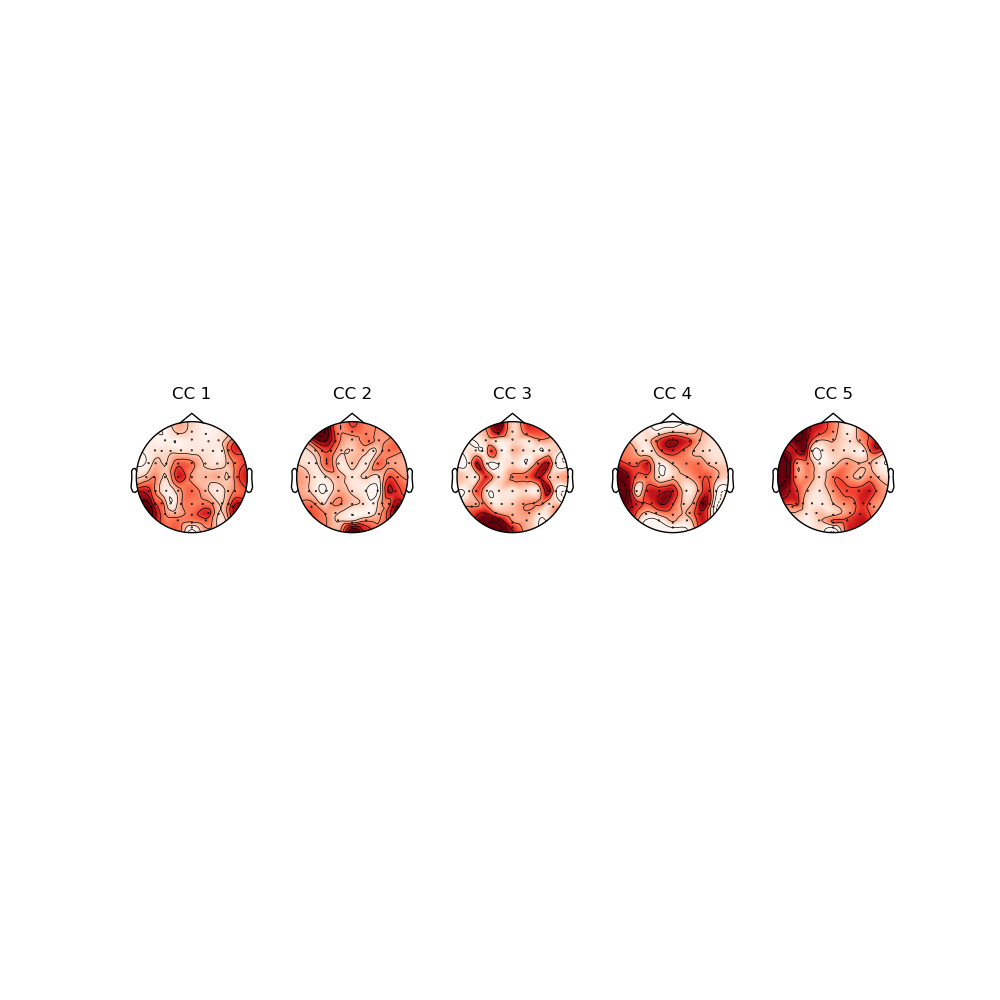

In [53]:
# Visualization: spatial (temporal) filter
forward_model = utils.forward_model(eeg_onesub, V_A_train, L_EEG, causalx)
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    mne.viz.plot_topomap(np.abs(forward_model[:,i]), create_info, ch_type='eeg', axes=ax, show=False)
    ax.set_title('CC '+str(i+1))
plt.show()

In [54]:
# A sanity check: GCCA-one subject + stimulus = CCA
# datalist = [eeg_onesub_list, mag_avg_list]
# Llist = [3, int(fs/2)]
# causal_list = [False, True]
# rhos= [1, 1]
# corr_train, corr_test, Wlist_train, Flist_train = utils.cross_val_GCCA_multi_mod(datalist, Llist, causal_list, rhos, fs, fold=10, n_components=5, regularization='lwcov', message=True, signifi_level=False, ISC=True)
# F_train = utils.F_organize(Flist_train[0], L=3, causal=False, avg=True)

# # Or use SI-GCCA
# # datalist = [eeg_onesub_list, mag_avg_list]
# # Llist = [3, int(fs/2)]
# # causal_list = [False, True]
# # rho= 1
# # corr_train, corr_test, Wlist_train, F_train = utils.cross_val_SI_GCCA(datalist, Llist, causal_list, rho, fs, fold=10, n_components=5, regularization='lwcov', message=True, signifi_level=False, ISC=True)

# biosemi_layout = mne.channels.read_layout('biosemi')
# create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
# create_info.set_montage('biosemi64')
# plt.close()
# # plt.figure()
# plt.figure(figsize=(10, 10))
# for i in range(5):
#     ax = plt.subplot(1, 5, i + 1)
#     mne.viz.plot_topomap(np.abs(F_train[:,i]), create_info, ch_type='eeg', axes=ax, show=False)
#     ax.set_title('CC '+str(i+1))
# plt.show()

Average correlation coefficients of the top 5 components on the training sets: [0.10484167 0.07224385 0.05147569 0.04446254 0.04136818]
Average correlation coefficients of the top 5 components on the test sets: [0.05662518 0.02262296 0.01553508 0.00873372 0.00925876]


In [65]:
conv_mtx = utils.block_Hankel(mag_avg, int(fs/2), causal=True)
eeg_conv = utils.block_Hankel(eeg_onesub, L_EEG, causal=False)
filtered_EEG = eeg_conv@V_A_train
filtered_Sti = conv_mtx@V_B_train
dt = times[1]-times[0]
grad = np.gradient(np.squeeze(mag_avg), dt)

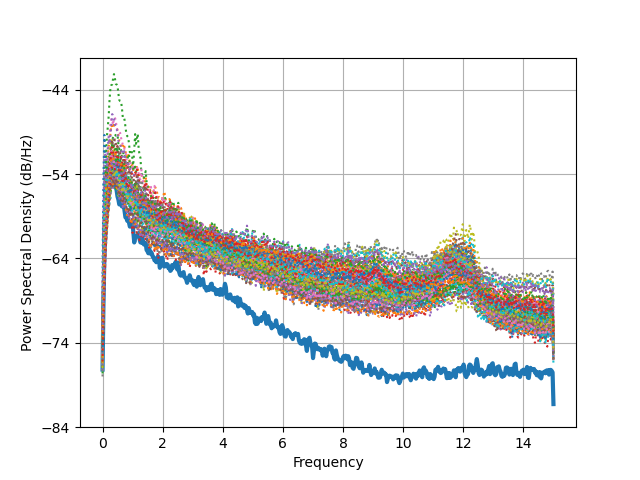

In [66]:
plt.close()
plt.psd(filtered_EEG[:,0], 1024, Fs=fs, linewidth=3)
for n in range(eeg_onesub.shape[1]):
    plt.psd(eeg_onesub[:,n], 1024, Fs=fs, linestyle=':')
plt.show()

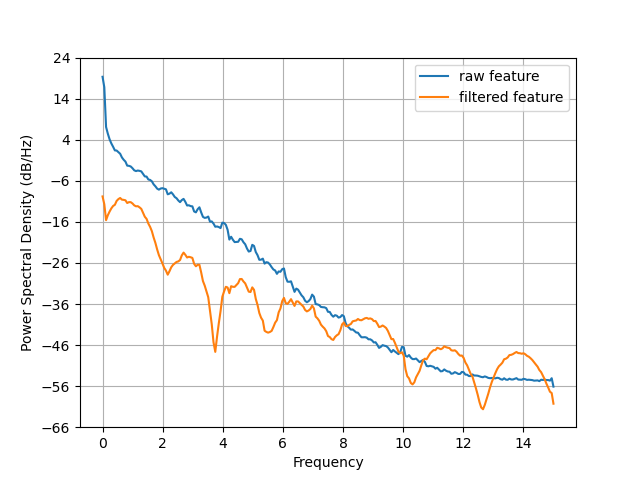

In [67]:
plt.close()
plt.psd(np.squeeze(mag_avg), 512, Fs=fs, label="raw feature")
plt.psd(filtered_Sti[:,0], 512, Fs=fs, label="filtered feature")
plt.legend()
plt.show()

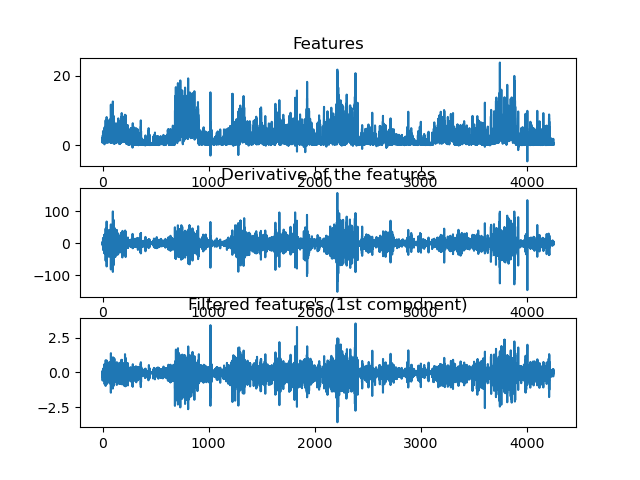

In [68]:
# Visualizations: temporal filter
plt.close()
compo = 1
ax1 = plt.subplot(311)
ax1.plot(times, mag_avg)
ax1.title.set_text('Features')
ax2 = plt.subplot(312, sharex = ax1)
ax2.plot(times, grad)
ax2.title.set_text('Derivative of the features')
ax3 = plt.subplot(313, sharex = ax1)
ax3.plot(times, filtered_Sti[:,compo-1])
ax3.title.set_text('Filtered features (1st component)')
plt.show()

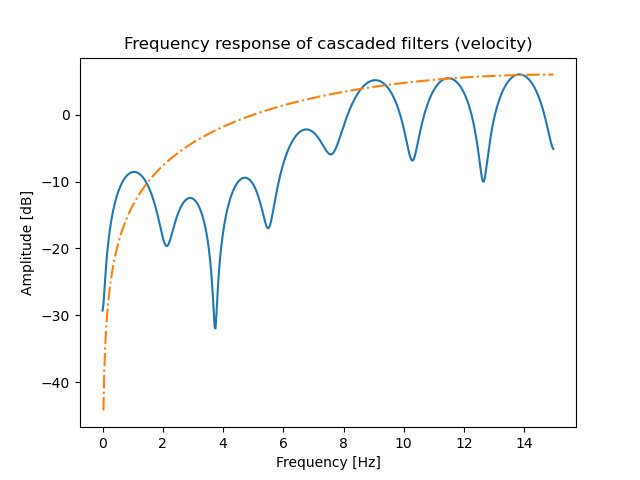

In [70]:
w, h = signal.freqz(b=V_B_train[:,0], a=1)
# h = h * np.exp(1j*15*w)
x = w * fs * 1.0 / (2 * np.pi)
y = 20 * np.log10(abs(h))

w_diff, h_diff = signal.freqz(b=[1,-1], a=1)


plt.close()
plt.plot(x,y)
plt.plot(x,20 * np.log10(abs(h_diff)),'-.')
# plt.plot(x,20 * np.log10(abs(h/h_diff)))
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.title('Frequency response of cascaded filters (velocity)')
plt.show()

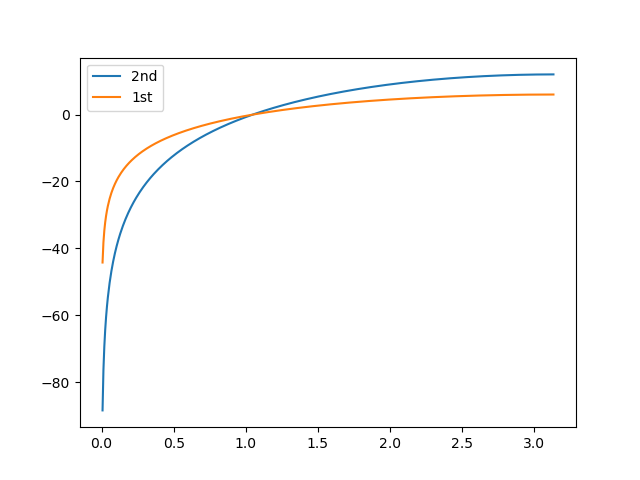

In [71]:
w1, h1 = signal.freqz(b=[1,-2,1], a=1)
w2, h2 = signal.freqz(b=[1,-1], a=1)
plt.close()
plt.plot(w1,20 * np.log10(abs(h1)), label="2nd")
plt.plot(w2,20 * np.log10(abs(h2)), label="1st")
# plt.set_ylabel('Amplitude [dB]')
# plt.set_xlabel('Frequency [Hz]')
# plt.set_title('Frequency response of CC 1')
plt.legend()
plt.show()

## GCCA

In [24]:
# GCCA-5 subjects
eeg_5 = [eeg[:,:,0:5] for eeg in eeg_multisub_list]
L= 3
causal = False
corr_train, corr_test, Wlist_train, Flist_train = utils.cross_val_GCCA(eeg_5, L, causal, fs, fold=10, n_components=10, regularization='lwcov', message=True, signifi_level=True, ISC=True)

100%|██████████| 1000/1000 [08:22<00:00,  1.99it/s]

Significance level: 0.006125510015185988
Average correlation coefficients of the top 10 components on the training sets: [0.08160244 0.07931371 0.0779904  0.076869   0.07564095 0.07432694
 0.07324583 0.0723371  0.07142659 0.07016134]
Average correlation coefficients of the top 10 components on the test sets: [0.00436419 0.00810714 0.00420055 0.00638179 0.0076174  0.00542515
 0.00633728 0.01032229 0.00442876 0.00345414]


In [25]:
# GCCA-all subjects
L= 3
causal = False
corr_train, corr_test, Wlist_train, Flist_train = utils.cross_val_GCCA(eeg_multisub_list, L, causal, fs, fold=10, n_components=10, regularization='lwcov', message=True, signifi_level=True, ISC=True)

100%|██████████| 1000/1000 [12:32<00:00,  1.33it/s]

Significance level: 0.004350461472552873
Average correlation coefficients of the top 10 components on the training sets: [0.07113425 0.06939597 0.06729156 0.06583293 0.06426559 0.06298538
 0.06217547 0.06129118 0.06104482 0.06012142]
Average correlation coefficients of the top 10 components on the test sets: [ 0.01726729  0.02297828  0.01403412  0.01357976  0.00188639  0.00213825
 -0.00219919  0.00315978  0.00148068  0.00307048]


In [28]:
# GCCA-all subjects + stimulus
datalist = [eeg_multisub_list, mag_avg_list]
Llist = [3, fs+1]
causal_list = [False, True]
rho = 1
corr_train, corr_test, Wlist_train, F_train = utils.cross_val_SI_GCCA(datalist, Llist, causal_list, rho, fs, fold=10, n_components=10, regularization='lwcov', message=True, signifi_level=True, ISC=True)

100%|██████████| 1000/1000 [08:02<00:00,  2.07it/s]

Significance level: 0.006268382163914464
Average correlation coefficients of the top 10 components on the training sets: [0.06492206 0.07922718 0.07734692 0.07723638 0.07582647 0.07515404
 0.07328164 0.07239763 0.07156383 0.07094393]
Average correlation coefficients of the top 10 components on the test sets: [0.01388999 0.00327854 0.01204734 0.00059811 0.00847594 0.00991928
 0.00828508 0.00662158 0.01323444 0.00432417]


In [42]:
# GCCA-all subjects + stimulus
datalist = [eeg_multisub_list, mag_avg_list]
Llist = [3, int(fs/2)]
causal_list = [False, True]
rho = utils.rho_sweep(datalist, np.linspace(-2,2,9), Llist, causal_list, fs, fold=10, n_components=5, message=True, iflist=False)
corr_train, corr_test, Wlist_train, Flist_train = utils.cross_val_SI_GCCA(datalist, Llist, causal_list, rho, fs, fold=10, n_components=10, regularization='lwcov', message=True, signifi_level=True, ISC=True)

Average ISC across different training sets when rho=10**-2.0: [0.11276476 0.1088483  0.10689662 0.10465058 0.10188075]
Average ISC across different test sets when rho=10**-2.0: [-0.00637809 -0.00706669  0.00253232  0.00716144  0.02280919]
Average ISC across different training sets when rho=10**-1.5: [0.11276475 0.10884847 0.1068966  0.10465053 0.10188082]
Average ISC across different test sets when rho=10**-1.5: [-0.00638626 -0.00705023  0.00252445  0.00716157  0.02280006]
Average ISC across different training sets when rho=10**-1.0: [0.1127646  0.10884893 0.10689643 0.10465023 0.10188093]
Average ISC across different test sets when rho=10**-1.0: [-0.00641428 -0.00699246  0.00249586  0.00716267  0.02276645]
Average ISC across different training sets when rho=10**-0.5: [0.11276187 0.10884845 0.10689386 0.10464642 0.10187943]
Average ISC across different test sets when rho=10**-0.5: [-0.00653253 -0.00672561  0.00234773  0.00717961  0.0225838 ]
Average ISC across different training sets w

100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]

Significance level: 0.010986937052468065
Average correlation coefficients of the top 10 components on the training sets: [0.11276476 0.1088483  0.10689662 0.10465058 0.10188075 0.10009421
 0.09768154 0.09603768 0.09412227 0.09212348]
Average correlation coefficients of the top 10 components on the test sets: [-0.00637809 -0.00706669  0.00253232  0.00716144  0.02280919  0.00257819
 -0.00149427  0.00856797  0.00286556  0.00350154]


In [ ]:
# Take high frequency info into account
# datalist = [mix_64[:,:,0:6], mag_avg]
# Llist = [3, fs+1]
# causal_list = [False, False]
# rhos = utils.rho_sweep(datalist, np.linspace(-2,2,9), Llist, causal_list, fs, fold=10, n_components=5, message=True, iflist=True)
# corr_train, corr_test, Wlist_train, Flist_train = utils.cross_val_GCCA_multi_mod(datalist, Llist, causal_list, rhos, fs, fold=10, n_components=10, regularization='lwcov', message=True, signifi_level=True, ISC=True)

## Visualization for components across each fold

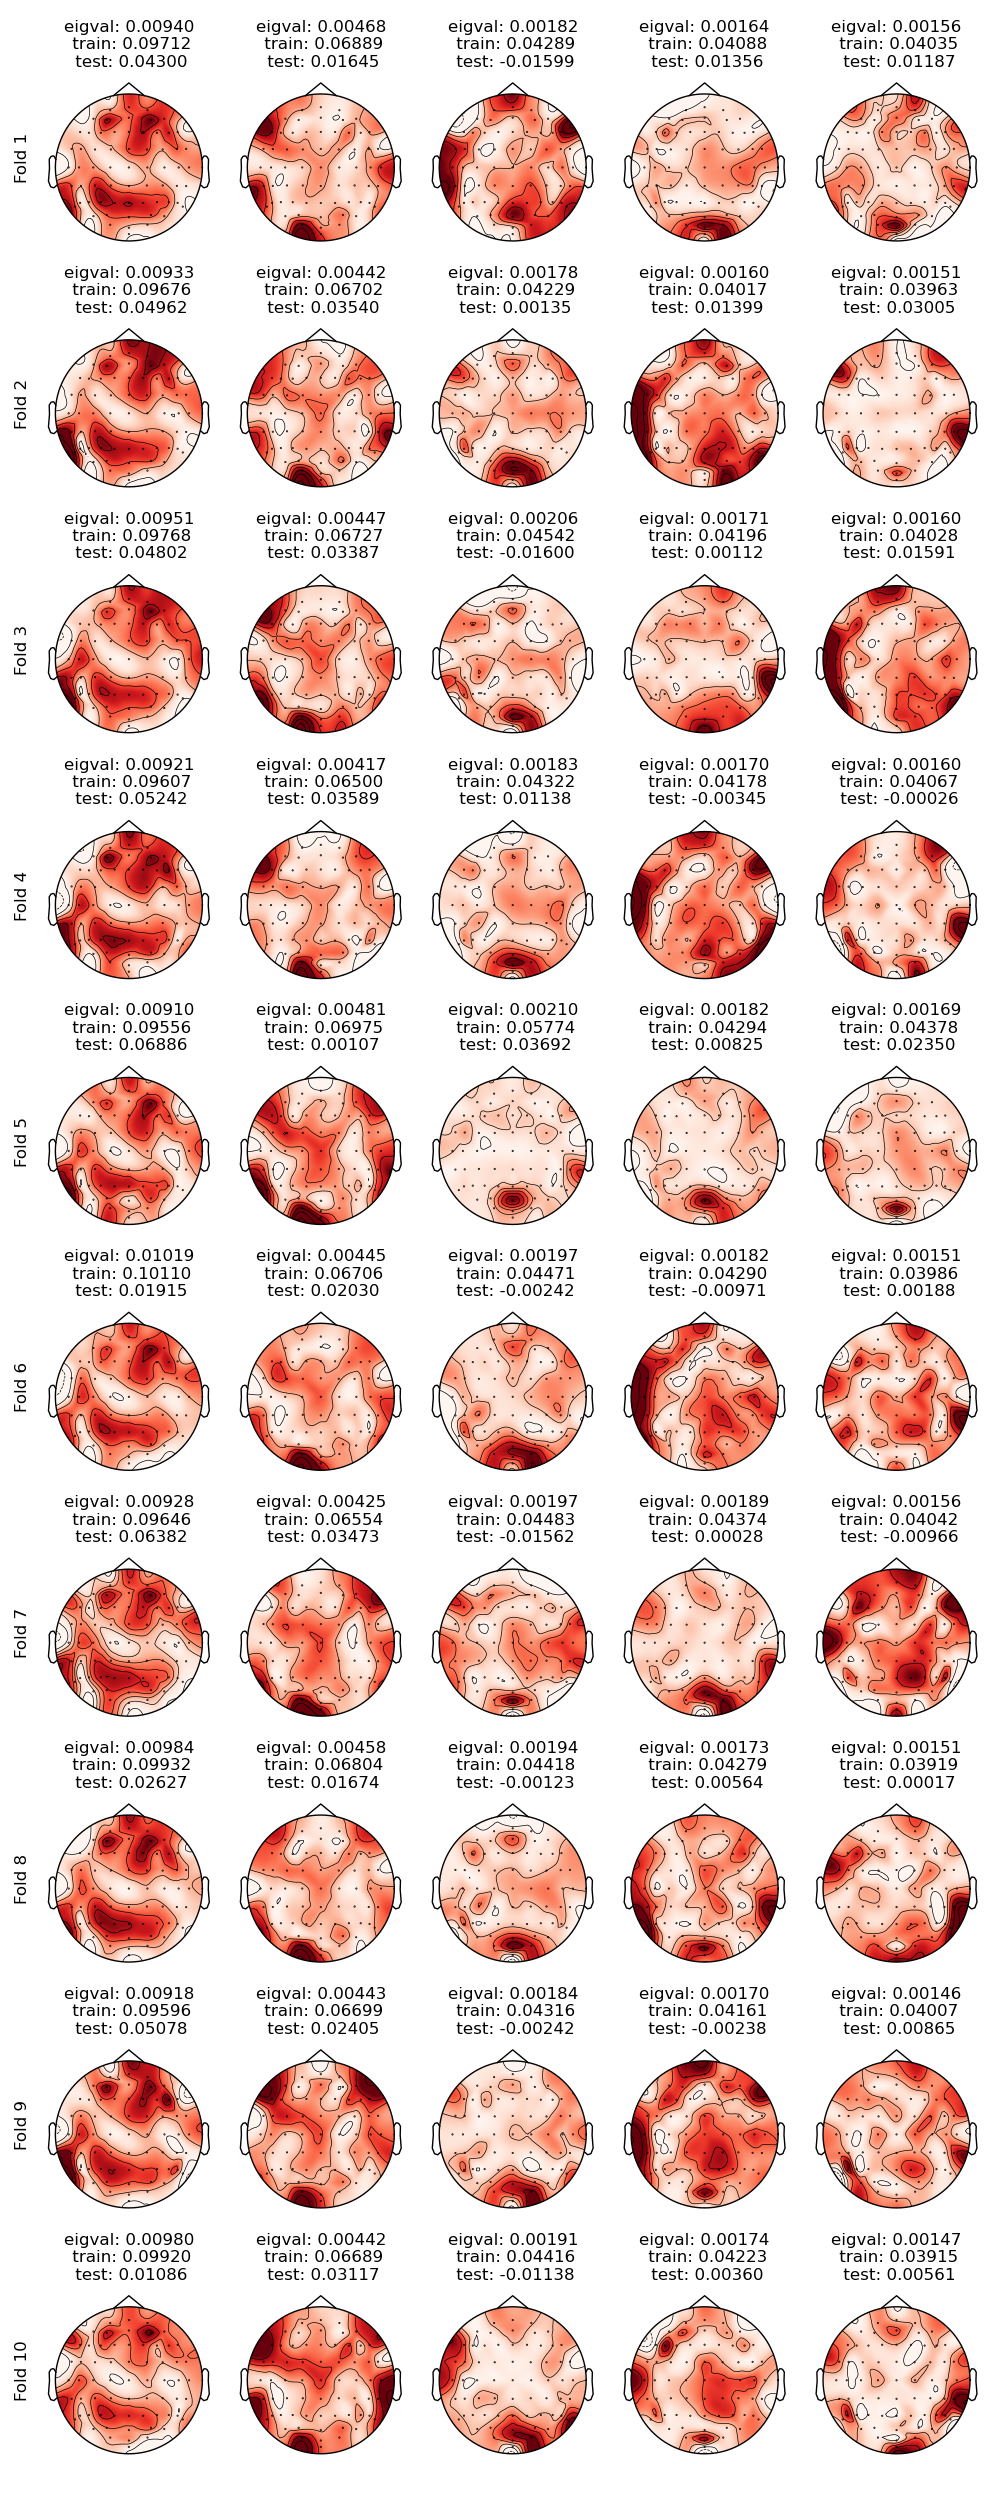

In [29]:
# CCA
n_components = 5
fold = 10
id_sub = 1
eeg_onesub = eeg_multisub_concat[:,:,id_sub-1]
eeg_onesub_list = [eeg[:,:,id_sub-1] for eeg in eeg_multisub_list]
mag_avg_list = [feats[:,8] for feats in features_list]
L_EEG = 3 # correlations can be higher if include time lags
L_feat = int(fs/2)
causalx = False
causaly = True
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')

Lam = np.zeros((fold, n_components))
corr_train = np.zeros((fold, n_components))
corr_test = np.zeros((fold, n_components))
plt.close()
fig, axes = plt.subplots(nrows=fold, ncols=n_components, figsize=(10, 25))
for idx in range(fold):
    EEG_train, EEG_test, Sti_train, Sti_test = utils.split_balance(eeg_onesub_list, mag_avg_list, fold=fold, fold_idx=idx+1)
    corr_train[idx,:], _, V_A_train, V_B_train, Lam[idx,:] = utils.cano_corr(EEG_train, Sti_train, Lx=L_EEG, Ly=L_feat, causalx=causalx, causaly=causaly, n_components=n_components, regularization='lwcov', K_regu=None)
    corr_test[idx,:], _, _, _, _ = utils.cano_corr(EEG_test, Sti_test, Lx=L_EEG, Ly=L_feat, causalx=causalx, causaly=causaly, n_components=n_components, regularization='lwcov', K_regu=None, V_A=V_A_train, V_B=V_B_train)
    forward_model = utils.forward_model(eeg_onesub, V_A_train, L_EEG, causalx)
    for i in range(n_components):
        mne.viz.plot_topomap(np.abs(forward_model[:,i]), create_info, ch_type='eeg', axes=axes[idx,i], show=False)
        axes[idx,i].set_title("eigval: {eigval:.5f}\n train: {corrtrain:.5f}\n test: {corrtest:.5f}".format(eigval=Lam[idx,i], corrtrain=corr_train[idx,i], corrtest=corr_test[idx,i]))
rows = ['Fold {}'.format(row) for row in range(1, fold+1)]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, size='large')
fig.tight_layout()
plt.show()
plt.savefig('figures/CCA_comp_'+str(id_sub)+'.png')

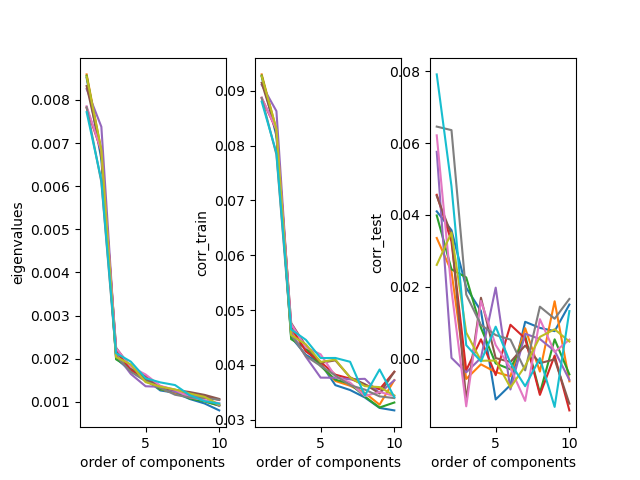

In [31]:
# CCA-eigenvalues
n_components = 10
fold = 10
id_sub = 7
eeg_onesub = eeg_multisub_concat[:,:,id_sub-1]
eeg_onesub_list = [eeg[:,:,id_sub-1] for eeg in eeg_multisub_list]
mag_avg_list = [feats[:,8] for feats in features_list]
L_EEG = 3 # correlations can be higher if include time lags
L_feat = int(fs/2)
causalx = False
causaly = True
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')

Lam = np.zeros((fold, n_components))
corr_train = np.zeros((fold, n_components))
corr_test = np.zeros((fold, n_components))
plt.close()
ax_eig = plt.subplot(1, 3, 1)
ax_eig.set_xlabel('order of components')
ax_eig.set_ylabel('eigenvalues')
ax_train = plt.subplot(1, 3, 2)
ax_train.set_xlabel('order of components')
ax_train.set_ylabel('corr_train')
ax_test = plt.subplot(1, 3, 3)
ax_test.set_xlabel('order of components')
ax_test.set_ylabel('corr_test')
for idx in range(fold):
    EEG_train, EEG_test, Sti_train, Sti_test = utils.split_balance(eeg_onesub_list, mag_avg_list, fold=fold, fold_idx=idx+1)
    corr_train[idx,:], _, V_A_train, V_B_train, Lam[idx,:] = utils.cano_corr(EEG_train, Sti_train, Lx=L_EEG, Ly=L_feat, causalx=causalx, causaly=causaly, n_components=n_components, regularization='lwcov', K_regu=None)
    corr_test[idx,:], _, _, _, _ = utils.cano_corr(EEG_test, Sti_test, Lx=L_EEG, Ly=L_feat, causalx=causalx, causaly=causaly, n_components=n_components, regularization='lwcov', K_regu=None, V_A=V_A_train, V_B=V_B_train)
    forward_model = utils.forward_model(eeg_onesub, V_A_train, L_EEG, causalx)
    ax_eig.plot(range(1, n_components+1), Lam[idx,:])
    ax_train.plot(range(1, n_components+1), corr_train[idx,:])
    ax_test.plot(range(1, n_components+1), corr_test[idx,:])
plt.show()

In [ ]:
# GCCA-5 subjects
n_components = 5
fold = 10
eeg_sub_list = [eeg[:,:,0:5] for eeg in eeg_multisub_list]
L = 3
causal = False
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')

Lam = np.zeros((fold, n_components))
corr_train = np.zeros((fold, n_components))
corr_test = np.zeros((fold, n_components))
plt.close()
fig, axes = plt.subplots(nrows=fold, ncols=n_components, figsize=(10, 25))
for idx in range(fold):
    train_list, test_list = utils.split_mm_balance([eeg_sub_list], fold=fold, fold_idx=idx+1)
    W_train, F_train, Lam[idx,:] = utils.GCCA(train_list[0], L, causal, n_components=n_components, regularization='lwcov')
    corr_train[idx,:] = utils.avg_corr_coe(train_list[0], W_train, L, causal, n_components=n_components)
    corr_test[idx,:] = utils.avg_corr_coe(test_list[0], W_train, L, causal, n_components=n_components)
    for i in range(n_components):
        mne.viz.plot_topomap(np.abs(F_train[:,i]), create_info, ch_type='eeg', axes=axes[idx,i], show=False)
        axes[idx,i].set_title("eigval: {eigval:.5f}\n train: {corrtrain:.5f}\n test: {corrtest:.5f}".format(eigval=Lam[idx,i], corrtrain=corr_train[idx,i], corrtest=corr_test[idx,i]))
rows = ['Fold {}'.format(row) for row in range(1, fold+1)]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, size='large')
fig.tight_layout()
plt.show()
plt.savefig('figures/GCCA_comp_5'+'.png')

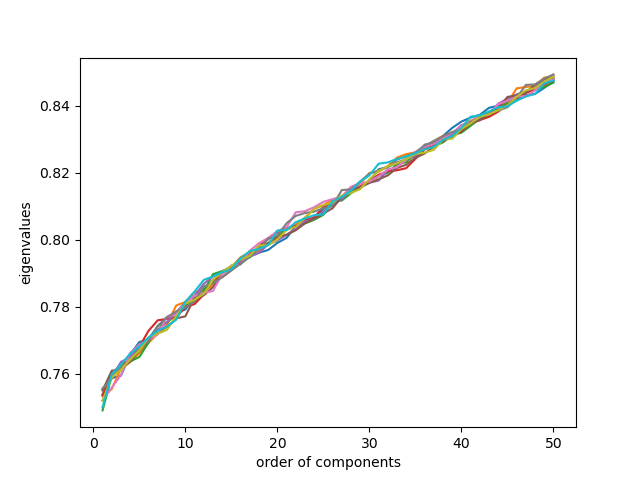

In [43]:
# GCCA-eigenvalues-5 subjects
n_components = 50
fold = 10
eeg_sub_list = [eeg[:,:,0:5] for eeg in eeg_multisub_list]
L = 3
causal = False
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')

Lam = np.zeros((fold, n_components))
corr_train = np.zeros((fold, n_components))
corr_test = np.zeros((fold, n_components))
plt.close()
for idx in range(fold):
    train_list, test_list = utils.split_mm_balance([eeg_sub_list], fold=fold, fold_idx=idx+1)
    _, _, Lam[idx,:]  = utils.GCCA(train_list[0], L, causal, n_components=n_components, regularization='lwcov')
    plt.plot(range(1,n_components+1), Lam[idx,:])
plt.xlabel('order of components')
plt.ylabel('eigenvalues')
plt.show()
plt.savefig('figures/GCCA_5_eigval.png')

In [ ]:
# SI-GCCA-5 subjects
n_components = 5
fold = 10
eeg_sub_list = [eeg[:,:,0:5] for eeg in eeg_multisub_list]
mag_avg_list = [feats[:,8] for feats in features_list]
nested_datalist = [eeg_sub_list, mag_avg_list]
Llist = [3, int(fs/2)]
causal_list = [False, True]
rho = 1
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')

Lam = np.zeros((fold, n_components))
corr_train = np.zeros((fold, n_components))
corr_test = np.zeros((fold, n_components))
plt.close()
fig, axes = plt.subplots(nrows=fold, ncols=n_components, figsize=(10, 25))
for idx in range(fold):
    train_list, test_list = utils.split_mm_balance(nested_datalist, fold=fold, fold_idx=idx+1)
    Wlist_train, F_train, Lam[idx,:] = utils.SI_GCCA(train_list, Llist, causal_list, n_components=n_components, rho=rho, regularization='lwcov')
    corr_train[idx,:] = utils.avg_corr_coe_multi_modal(train_list, Wlist_train, Llist, causal_list, n_components=n_components, ISC=True)
    corr_test[idx,:] = utils.avg_corr_coe_multi_modal(test_list, Wlist_train, Llist, causal_list, n_components=n_components, ISC=True)
    for i in range(n_components):
        mne.viz.plot_topomap(np.abs(F_train[:,i]), create_info, ch_type='eeg', axes=axes[idx, i], show=False)
        axes[idx, i].set_title("eigval: {eigval:.5f}\n train: {corrtrain:.5f}\n test: {corrtest:.5f}".format(eigval=Lam[idx,i], corrtrain=corr_train[idx,i], corrtest=corr_test[idx,i]))
rows = ['Fold {}'.format(row) for row in range(1, fold+1)]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, size='large')
fig.tight_layout()
plt.show()
plt.savefig('figures/SI_GCCA_5_comp.png')

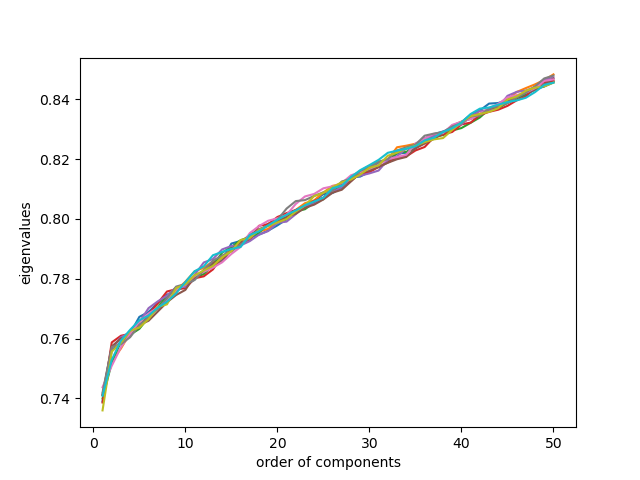

In [48]:
# SI-GCCA-5 subjects-eigenvalues
n_components = 50
fold = 10
eeg_sub_list = [eeg[:,:,0:5] for eeg in eeg_multisub_list]
mag_avg_list = [feats[:,8] for feats in features_list]
nested_datalist = [eeg_sub_list, mag_avg_list]
Llist = [3, int(fs/2)]
causal_list = [False, True]
rho = 1
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')

Lam = np.zeros((fold, n_components))
corr_train = np.zeros((fold, n_components))
corr_test = np.zeros((fold, n_components))
plt.close()
for idx in range(fold):
    train_list, test_list = utils.split_mm_balance(nested_datalist, fold=fold, fold_idx=idx+1)
    _, _, Lam[idx,:] = utils.SI_GCCA(train_list, Llist, causal_list, n_components=n_components, rho=rho, regularization='lwcov')
    plt.plot(range(1,n_components+1), Lam[idx,:])
plt.xlabel('order of components')
plt.ylabel('eigenvalues')
plt.show()
plt.savefig('figures/SI_GCCA_5_eigval.png')

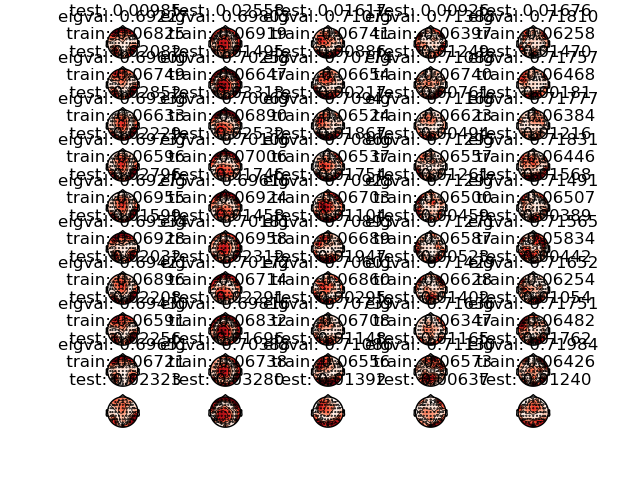

In [12]:
# GCCA_multi_mod-5 subjects
# n_components = 5
# fold = 10
# mag_avg_list = [feats[:,8] for feats in features_list]
# nested_datalist = [eeg_multisub_list, mag_avg_list]
# Llist = [3, int(fs/2)]
# causal_list = [False, True]
# rhos = [1, 1]
# biosemi_layout = mne.channels.read_layout('biosemi')
# create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
# create_info.set_montage('biosemi64')

# Lam = np.zeros((fold, n_components))
# corr_train = np.zeros((fold, n_components))
# corr_test = np.zeros((fold, n_components))
# plt.close()
# for idx in range(fold):
#     train_list, test_list = utils.split_mm_balance(nested_datalist, fold=fold, fold_idx=idx+1)
#     Wlist_train, Flist_train, Lam[idx,:] = utils.GCCA_multi_modal(train_list, Llist, causal_list, n_components=n_components, rhos=rhos, regularization='lwcov')
#     corr_train[idx,:] = utils.avg_corr_coe_multi_modal(train_list, Wlist_train, Llist, causal_list, n_components=n_components, ISC=True)
#     corr_test[idx,:] = utils.avg_corr_coe_multi_modal(test_list, Wlist_train, Llist, causal_list, n_components=n_components, ISC=True)
#     forward = utils.F_organize(Flist_train[0], L=3, causal=False, avg=True)
#     for i in range(5):
#         ax = plt.subplot(fold, n_components, idx*n_components + i + 1)
#         mne.viz.plot_topomap(np.abs(forward[:,i]), create_info, ch_type='eeg', axes=ax, show=False)
#         ax.set_title("eigval: {eigval:.5f}\n train: {corrtrain:.5f}\n test: {corrtest:.5f}".format(eigval=Lam[idx,i], corrtrain=corr_train[idx,i], corrtest=corr_test[idx,i]))
# plt.show()

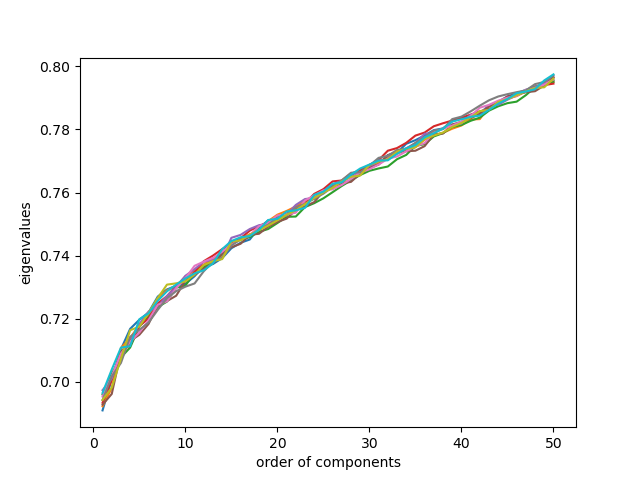

In [13]:
# GCCA_multi_mod-5 subjects-eigenvalues
# n_components = 50
# fold = 10
# mag_avg_list = [feats[:,8] for feats in features_list]
# nested_datalist = [eeg_multisub_list, mag_avg_list]
# Llist = [3, int(fs/2)]
# causal_list = [False, True]
# rhos = [1, 1]
# biosemi_layout = mne.channels.read_layout('biosemi')
# create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
# create_info.set_montage('biosemi64')

# Lam = np.zeros((fold, n_components))
# corr_train = np.zeros((fold, n_components))
# corr_test = np.zeros((fold, n_components))
# plt.close()
# for idx in range(fold):
#     train_list, test_list = utils.split_mm_balance(nested_datalist, fold=fold, fold_idx=idx+1)
#     Wlist_train, Flist_train, Lam[idx,:]  = utils.GCCA_multi_modal(train_list, Llist, causal_list, n_components=n_components, rhos=rhos, regularization='lwcov')
#     corr_train[idx,:] = utils.avg_corr_coe_multi_modal(train_list, Wlist_train, Llist, causal_list, n_components=n_components, ISC=True)
#     corr_test[idx,:] = utils.avg_corr_coe_multi_modal(test_list, Wlist_train, Llist, causal_list, n_components=n_components, ISC=True)
#     forward = utils.F_organize(Flist_train[0], L=3, causal=False, avg=True)
#     plt.plot(range(1,n_components+1), Lam[idx,:])
# plt.xlabel('order of components')
# plt.ylabel('eigenvalues')
# plt.show()